## GBGPU Tutorial

`GBGPU` is a GPU-accelerated version of the `FastGB` waveform which has been developed by Neil Cornish, Tyson Littenberg, Travis Robson, and Stas Babak. It computes gravitational waveforms for Galactic binary systems observable by LISA using a fast/slow-type decomposition. For more details on the original construction of `FastGB` see [arXiv:0704.1808](https://arxiv.org/abs/0704.1808).

The current version of the code is very closely related to the implementation of `FastGB` in the LISA Data Challenges' Python code package. The waveform code is entirely Python-based. It is about 1/2 the speed of the full C version, but much simpler in Python for right now. There are also many additional functions including fast likelihood computations for individual Galactic binaries, as well as fast C-based methods to combine waveforms into global fitting templates. 

The code is CPU/GPU agnostic. CUDA and NVIDIA GPUs are required to run these codes for GPUs.

See the [documentation](https://mikekatz04.github.io/GBGPU/html/index.html) for more details. This code was designed for (# TODO: add new arxiv number). If you use any part of this code, please cite (# TODO: add new arxiv number), its [Zenodo page](https://zenodo.org/record/6500434#.YmpofxNBzlw), [arXiv:0704.1808](https://arxiv.org/abs/0704.1808), and [arXiv:1806.00500](https://arxiv.org/abs/1806.00500). 

In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

from gbgpu.gbgpu import GBGPU
from gbgpu.thirdbody import GBGPUThirdBody

from gbgpu.utils.constants import *
from gbgpu.utils.utility import *

from ldc.lisa.noise import get_noise_model
from ldc.common.series import TimeSeries, window
import ldc.waveform.fastGB as fastGB

/home/stefan/anaconda3/envs/ldc_gbgpu/lib/python3.8/site-packages/gbgpu-0.1-py3.8-linux-x86_64.egg/gbgpu/gbgpu.py:24: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")
/home/stefan/anaconda3/envs/ldc_gbgpu/lib/python3.8/site-packages/gbgpu-0.1-py3.8-linux-x86_64.egg/gbgpu/utils/utility.py:15: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")


## Generating Galactic binary waveforms

Initialize the waveform class.

In [2]:
gb = GBGPU(use_gpu=True)

Setup all the binary information. GBGPU operates in a vectorized manner, so it takes arrays of parameters as inputs.

In [3]:
dt = 15.0
Tobs = 1.0 * YEAR


# number of points in waveform
# if None, will determine inside the code based on amp, f0 (and P2 if running third-body waveform)
N = None

# number of binaries to batch
num_bin = 10

# parameters
amp = 2e-23  # amplitude
f0 = 2e-3  # f0
fdot = 7.538331e-18  # fdot
fddot = 0.0 # fddot
phi0 = 0.1  # initial phase
iota = 0.2  # inclination
psi = 0.3  # polarization angle
lam = 0.4  # ecliptic longitude
beta_sky = 0.5  # ecliptic latitude

# parameters
amp =  4.1204141965278374e-23  # amplitude
f0 = 0.004433557542242183  # f0
fdot = 7.39441302760258e-16 # fdot
fddot = 0.0 # fddot
phi0 = 2.295212550  # initial phase
iota = 0.96958009  # inclination
psi = 2.39042002 # polarization angle
lam = -1.5329 # ecliptic longitude
beta_sky =  0.1499696035197409  # ecliptic latitude

# pGB = {'Amplitude': 4.1204141965278374e-23, 'EclipticLatitude': 0.1499696035197409, 'EclipticLongitude': -1.5329064543709758, 'Frequency': 0.004433557542242183, 'FrequencyDerivative': 7.39441302760258e-16, 'Inclination': 0.9695800951653658, 'InitialPhase': 2.2952125504283734, 'Polarization': 2.3904200261278317}

pGB = {'Amplitude': amp, 'Frequency': f0, 'FrequencyDerivative': fdot, 'InitialPhase': phi0, 'Inclination': iota, 'Polarization': psi, 'EclipticLongitude': lam, 'EclipticLatitude': beta_sky}
# for batching
amp_in = np.full(num_bin, amp)
f0_in = np.full(num_bin, f0)
fdot_in = np.full(num_bin, fdot)
fddot_in = np.full(num_bin, fddot)
phi0_in = np.full(num_bin, phi0)
iota_in = np.full(num_bin, iota)
psi_in = np.full(num_bin, psi)
lam_in = np.full(num_bin, lam)
beta_sky_in = np.full(num_bin, beta_sky)


Generate the waveforms.

/home/stefan/anaconda3/envs/ldc_gbgpu/lib/python3.8/site-packages/gbgpu-0.1-py3.8-linux-x86_64.egg/gbgpu/utils/utility.py:264: UserWarning: Sensitivity information not available. The number of points in the waveform will not be determined byt the signal strength without the availability of the Sensitivity.
  warnings.warn(


signal length: (256,)
0.0044305575422421825


/home/stefan/anaconda3/envs/ldc_gbgpu/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


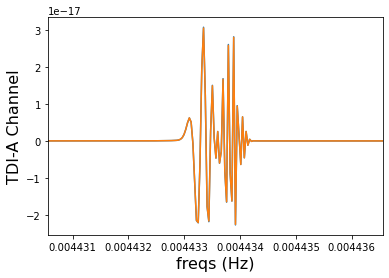

In [4]:
params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

gb.run_wave(*params, N=N, dt=dt, T=Tobs, oversample=4)

# pGB['InitialPhase'] *= -1
GB = fastGB.FastGB(delta_t=dt, T=Tobs)
Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=4, simulator="synthlisa")
Af = (Zs - Xs)/np.sqrt(2.0)

# signal from first binary
A = gb.A[0]
freqs = gb.freqs[0]
print("signal length:", A.shape)
plt.plot(freqs.get(), A.get())
plt.plot(Af.f, Af)
plt.ylabel("TDI-A Channel", fontsize=16)
plt.xlabel("freqs (Hz)", fontsize=16)
dx = 3e-6
plt.xlim(f0 - dx, f0 + dx)
print(f0-dx)

In [25]:
print(len(Xs))

256


## Adding additional GB astrophysics

It is possible in `GBGPU` to inherit a special class [(`gbgpu.gbgpu.InheritGBGPU`)](https://mikekatz04.github.io/GBGPU/html/user/derivedwaves.html#gbgpu.gbgpu.InheritGBGPU) that allows users to add other types of astrophysics to the FastGB waveform. This requires that the astrophysical effects vary slowly.

The methods that need to be written when adding astrophysics are `prepare_additional_args`, `special_get_N`, `shift_frequency`, and `add_to_argS`.

`prepare_additional_args`: Prepares all arguments beyond the base GB parameters.

`special_get_N`: Implemented if the new setup puts limitations on the sampling rate in the time-domain for the slow part of the waveform. 

`shift_frequency`: Shifts the frequency in the slow computation. 

`add_to_argS`: Adjusts the phasing in the transfer function of the slow waveform.  

See [`gbgpu.thirdbody.GBGPUThirdBody`](https://mikekatz04.github.io/GBGPU/html/user/derivedwaves.html#gbgpu.thirdbody.ThirdBody) for an example and more information.

### Example: Third-body in orbit around the inner binary

In [1]:
gb_third = GBGPUThirdBody(use_gpu=False)

A2 = 400.0  # third body amplitude parameter
varpi = 0.0  # varpi phase parameter
e2 = 0.3  # eccentricity of third body
P2 = 1.2  # period of third body
T2 = 0.5 * P2  # time of periapsis passage of third body


A2_in = np.full(num_bin, A2)
P2_in = np.full(num_bin, P2)
varpi_in = np.full(num_bin, varpi)
e2_in = np.full(num_bin, e2)
T2_in = np.full(num_bin, T2)

NameError: name 'GBGPUThirdBody' is not defined

In [2]:
params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in, A2_in, varpi_in, e2_in, P2_in, T2_in]
)

gb_third.run_wave(*params, N=N, dt=dt, T=Tobs, oversample=2)

# signal from first binary
A_third = gb_third.A[0]
freqs = gb_third.freqs[0]
print("Third-body signal length:", A_third.shape)
plt.plot(freqs, np.abs(A.get()), label="No third body")
plt.plot(freqs, np.abs(A_third), label="No third body")
plt.ylabel("TDI-A Channel", fontsize=16)
plt.xlabel("freqs (Hz)", fontsize=16)
dx = 7e-7
plt.xlim(f0 - dx, f0 + dx)

NameError: name 'np' is not defined

## Calculating the Information Matrix

In [21]:
params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

inds = np.array([0, 1, 2, 4, 5, 6, 7, 8])

info_matrix = gb.information_matrix(
    params,
    easy_central_difference=False,
    eps=1e-9,
    inds=inds,
    N=1024,
    dt=dt,
    T=Tobs,
)

cov = np.linalg.pinv(info_matrix)

cov.shape

ModuleNotFoundError: Sensitivity curve information through LISA Analysis Tools is not available. Stock option for Information matrix will not work. Please install LISA Analysis Tools (lisatools).

Covariance Matrix for first binary:

In [8]:
cov[0]

array([[ 2.59077356e-03, -1.73881105e-11,  5.79303854e-06,
        -9.34813784e-06, -1.04002859e-04, -5.60750479e-05,
         1.67605334e-05,  9.25171196e-05],
       [-1.73881104e-11,  1.22082662e-14,  1.64237500e-09,
        -2.54833541e-09,  1.37966733e-13, -1.52900681e-08,
         5.16215869e-10, -3.66331834e-10],
       [ 5.79303858e-06,  1.64237500e-09,  3.24595981e-04,
        -5.03938709e-04, -3.47043395e-07, -3.02364387e-03,
         1.81105534e-05,  1.29976949e-04],
       [-9.34813786e-06, -2.54833541e-09, -5.03938709e-04,
         7.82376988e-04,  5.53048679e-07,  4.69427999e-03,
        -2.96655655e-05, -2.05333283e-04],
       [-1.04002859e-04,  1.37967094e-13, -3.47043323e-07,
         5.53048569e-07,  4.17508525e-06,  3.31774245e-06,
        -6.68420959e-07, -3.78390944e-06],
       [-5.60750482e-05, -1.52900681e-08, -3.02364387e-03,
         4.69427999e-03,  3.31774311e-06,  2.81657883e-02,
        -1.78010037e-04, -1.23202090e-03],
       [ 1.67605334e-05,  5.162158

Standard deviation on the marginalized parameters:

In [9]:
params[inds, 0] * cov[0].diagonal() ** (1/2)

array([1.01799284e-24, 2.20982046e-10, 1.35814698e-19, 2.79710026e-03,
       4.08660507e-04, 5.03479985e-02, 1.57517708e-02, 2.25836812e-02])

Plot the Information Matrix ellipse for the intial frequency and frequency derivative:

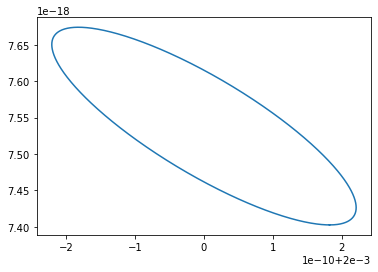

In [10]:
ind1 = 1 
ind2 = 2
inds_get = np.array([
    [ind1, ind1],
    [ind1, ind2],
    [ind2, ind1],
    [ind2, ind2]
]).T
sub_mat = cov[0][tuple(inds_get)].reshape(2, 2)

# calculate and draw covariance ellipse
a, b, b, c = sub_mat.flatten()

lam1 = (a + c) / 2. + np.sqrt(((a-c)/2) ** 2 + b ** 2)
lam2 = (a + c) / 2. - np.sqrt(((a-c)/2) ** 2 + b ** 2)

if b == 0. and a >= c:
    theta = 0.0
elif b == 0. and a < c:
    theta = np.pi / 2.
else:
    theta = -np.arctan2(lam1 - a, b)

t_vals = np.linspace(0., 2 * np.pi, 1000)
x = np.sqrt(lam1) * np.cos(theta) * np.cos(t_vals) - np.sqrt(lam2) * np.sin(theta) * np.sin(t_vals)
y = np.sqrt(lam1) * np.sin(theta) * np.cos(t_vals) + np.sqrt(lam2) * np.cos(theta) * np.sin(t_vals)

x_in = params[1, 0] * (1 + x)
y_in = params[2, 0] * (1 + y)
plt.plot(x_in, y_in)

## Utility functions

`GBGPU` provides many utility functions. Below are some examples of `GBGPU` utility functions. This may not include all utility functions. See the [utility documentation](https://mikekatz04.github.io/GBGPU/html/user/utils.html#gbgpu-utility-functions) for all included utility functions.

### Get the instantaneous gravitational wave frequency

Given $f_0$, $\dot{f}_0$, and $\ddot{f}_0$ calculate the instantaneous frequency of the gravitational waves approximating the frequency evolution to quadratic order:

Text(0, 0.5, '$f_{gw}$ (Hz)')

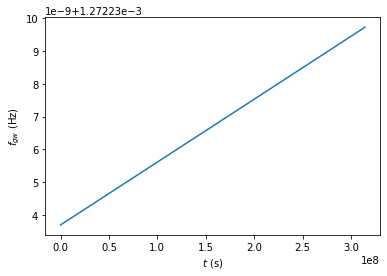

In [22]:
num = 15
f0 = np.random.uniform(0.001, 0.002, num)
fdot = np.random.uniform(1e-17, 2e-17, num)
fddot = np.random.uniform(1e-28, 2e-28, num)

t = np.arange(0.0, 10 * YEAR, YEAR/200)

# cast t to be for all binaries
t = t[None, :]

f = get_fGW(f0, fdot, fddot, t)

plt.plot(t[0], f[0])
plt.xlabel(r"$t$ (s)")
plt.ylabel(r"$f_{gw}$ (Hz)")


### Get amplitude (for slowly evolving source)

In [23]:
m1 = np.full(num, 0.2)
m2 = np.full(num, 0.1)
f0 = np.full(num, 0.1)
d = np.full(num, 6.0)  # kpc
amp = get_amplitude(m1, m2, f0, d)

print(amp)

[6.37190427e-23 6.37190427e-23 6.37190427e-23 6.37190427e-23
 6.37190427e-23 6.37190427e-23 6.37190427e-23 6.37190427e-23
 6.37190427e-23 6.37190427e-23 6.37190427e-23 6.37190427e-23
 6.37190427e-23 6.37190427e-23 6.37190427e-23]


### Get $\dot{f}$

In [24]:
m1 = np.full(num, 0.2)
m2 = np.full(num, 0.1)
f0 = np.full(num, 0.001)

fdot = get_fdot(f0, m1=m1, m2=m2)

print(fdot)

[1.73056526e-19 1.73056526e-19 1.73056526e-19 1.73056526e-19
 1.73056526e-19 1.73056526e-19 1.73056526e-19 1.73056526e-19
 1.73056526e-19 1.73056526e-19 1.73056526e-19 1.73056526e-19
 1.73056526e-19 1.73056526e-19 1.73056526e-19]


### Determine necessary sampling rate in the time-domin

In [25]:
get_N(amp, f0, Tobs, oversample=1)

array([256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256,
       256, 256])

### Adjust OMP usage in C functions

When using openMP, it defaults to using all threads. To limit this, use `gbgpu.utils.utility.omp_set_num_threads`.

In [26]:
omp_set_num_threads(2)

## Citations

You can access the necessary citations for the specific waveforms with the `citation` property.

In [16]:
print(gb.citation)


@software{michael_l_katz_2022_6500434,
  author       = {Michael L. Katz},
  title        = {mikekatz04/GBGPU: First official public release!},
  month        = apr,
  year         = 2022,
  publisher    = {Zenodo},
  version      = {v1.0.0},
  doi          = {10.5281/zenodo.6500434},
  url          = {https://doi.org/10.5281/zenodo.6500434}
}

@article{Cornish:2007if,
    author = "Cornish, Neil J. and Littenberg, Tyson B.",
    title = "{Tests of Bayesian Model Selection Techniques for Gravitational Wave Astronomy}",
    eprint = "0704.1808",
    archivePrefix = "arXiv",
    primaryClass = "gr-qc",
    doi = "10.1103/PhysRevD.76.083006",
    journal = "Phys. Rev. D",
    volume = "76",
    pages = "083006",
    year = "2007"
}

@article{Robson:2018svj,
    author = "Robson, Travis and Cornish, Neil J. and Tamanini, Nicola and Toonen, Silvia",
    title = "{Detecting hierarchical stellar systems with LISA}",
    eprint = "1806.00500",
    archivePrefix = "arXiv",
    primaryClass = "